## Model 1: Interlinked economies

The objective of this model is to learn to predict a multi-variate timeseries from another multivariate timeseries. Global human and technological development indicators are used to predict country-level consumer price inflation rates. Dimension reduction is performed using a generator architecture that learns the unobserved world-aggregate economic indicators from from country-level multivariate timeseries indicators. The conditional seq2seq multivariate will be optimised using a GAN that discriminates 'fake' world aggregate features learnt by the (TBD) generator from 'real' country-level metastatistics created based on handcrafted aggregations of the observations.

##### Open issues

* multidimensionality of the data
* normalization: over divisors or across all variables?

#### Features
------------

Multivariate global human and technological development indicator timeseries aggregated across nations using hand-crafted rules


#### Labels
----------

Consumer price inflation levels for the following countries:

* Singapore
* Switzerland
* Netherlands
* Japan
* France
* United States
* China
* India
* Brazil
* Colombia
* Indonesia
* Senegal
* Ghana

#### Training
------------

Training is done on a feature - single country basis.

### Load and prepare the data

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format

In [3]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [4]:
country = 'Switzerland'

In [5]:
country_labels = ['Brazil', 'China', 'Colombia', 'France', 'Ghana', 'India', 'Indonesia', 'Japan', 'Netherlands',
                  'Senegal', 'Singapore', 'Switzerland', 'United States']

In [6]:
assert country in country_labels

#### Load and combine the features and labels

In [7]:
features_df = pd.read_csv('features/m_one/world_aggregate.csv', sep=';', header=0)
labels_df = pd.read_csv('features/m_one/labels_interpolated.csv', sep=';', header=0)

In [8]:
features_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,electricity access,co2 emissions,electricity consumption,mobile subscriptions,newborns,overweight,rural population,unemployed,urban population,workers
0,1960-01-01,0.0000,0.0000,0.0000,0.0517,0.0000,0.0000,0.0000,0.0019,45.2673,...,0.0000,2.1968,0.4982,0.0000,0.0318,0.0000,0.6634,0.0014,0.3362,0.0232
1,1960-02-01,0.0000,0.0000,0.0000,0.0517,0.0000,0.0000,0.0000,0.0019,45.3268,...,0.0000,2.1920,0.5003,0.0000,0.0317,0.0000,0.6630,0.0014,0.3367,0.0232
2,1960-03-01,0.0000,0.0000,0.0000,0.0518,0.0000,0.0000,0.0000,0.0019,45.3863,...,0.0000,2.1872,0.5024,0.0000,0.0316,0.0000,0.6626,0.0014,0.3371,0.0232
3,1960-04-01,0.0000,0.0000,0.0000,0.0519,0.0000,0.0000,0.0000,0.0019,45.4458,...,0.0000,2.1825,0.5045,0.0000,0.0316,0.0000,0.6622,0.0015,0.3375,0.0232
4,1960-05-01,0.0000,0.0000,0.0000,0.0520,0.0000,0.0000,0.0000,0.0019,45.5052,...,0.0000,2.1777,0.5066,0.0000,0.0315,0.0000,0.6617,0.0015,0.3379,0.0232


In [9]:
labels_df.head()

,date,Brazil,China,Colombia,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0581,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0602,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0623,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0643,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0664,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


In [10]:
combined_df = pd.concat([features_df, labels_df.drop(columns=['date'])], axis=1)

In [11]:
combined_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0000,0.0517,0.0000,0.0000,0.0000,0.0019,45.2673,...,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0000,0.0517,0.0000,0.0000,0.0000,0.0019,45.3268,...,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0000,0.0518,0.0000,0.0000,0.0000,0.0019,45.3863,...,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0000,0.0519,0.0000,0.0000,0.0000,0.0019,45.4458,...,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0000,0.0520,0.0000,0.0000,0.0000,0.0019,45.5052,...,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


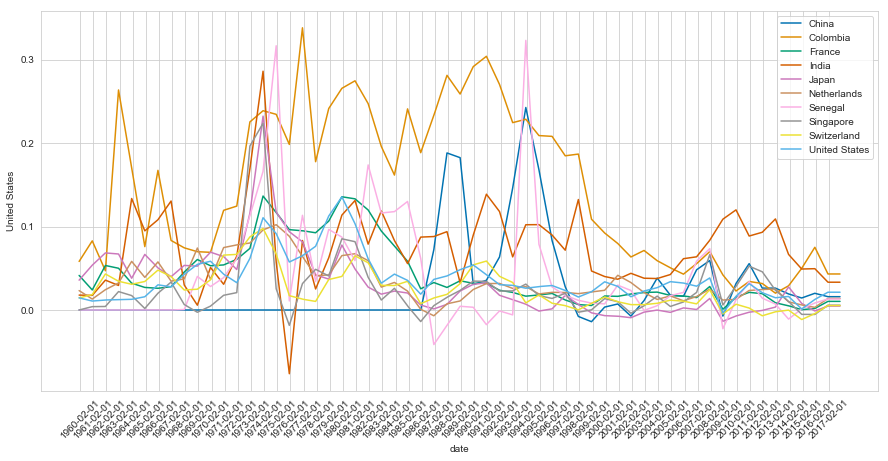

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
[sns.lineplot(x='date', y=c, markers=True, ax=ax, label=c, data=combined_df) for c in list(filter(lambda x: x not in ['Brazil', 'Indonesia', 'Ghana'], country_labels))]

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 12 == 1:
        xticks[i].set_visible(True)
    else:
        xticks[i].set_visible(False)

ax.set_xticklabels(combined_df['date'], rotation=45);

In [13]:
combined_df.columns

Index(['date', 'bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'imports of goods and services', 'listed companies',
       'manufacturing value added', 'r and d spend', 'services trade', 'trade',
       'government debt service', 'government interest payments external debt',
       'government tax revenue', 'birth deaths', 'broadband subscriptions',
       'electricity access', 'co2 emissions', 'electricity consumption',
       'mobile subscriptions', 'newborns', 'overweight', 'rural population',
       'unemployed', 'urban population', 'workers', 'Brazil', 'China',
       'Colombia', 'France', 'Ghana', 'India', 'Indonesia', 'Japa

In [14]:
base_feature_df = combined_df[['bank capital to assets ratio', 'bank nonperforming loans', 'cereal yield',
                               'energy imports', 'food exports', 'high-tech exports', 'inflation',
                               'lending interest rate', 'life expectancy', 'population density', 'real interest rate',
                               'broad money', 'exports of goods and services', 'gross domestic savings',
                               'high-tech value added', 'household consumption expenditure',
                               'imports of goods and services', 'listed companies', 'manufacturing value added',
                               'r and d spend', 'services trade', 'trade', 'government debt service',
                               'government interest payments external debt', 'government tax revenue', 'birth deaths',
                               'broadband subscriptions', 'electricity access', 'co2 emissions',
                               'electricity consumption', 'mobile subscriptions', 'newborns', 'overweight',
                               'rural population', 'unemployed', 'urban population', 'workers', country]]

In [15]:
base_feature_df.to_csv('features/m_one/combined_%s.csv' % country.lower(), sep=',', index=False)

### Model architecture
-----------------------

### Exploration 1

**Multivariate LSTM**, see https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- Num observations source dataset: 684 (using lagshift, 1960-2016 inclusive monthly)
- Num sequences (@ sequence length 6): 116.
- Batch size: 8 sequences (although `size=48` would lead to more stable training)

In [16]:
base_feature_df['label'] = base_feature_df[country].shift(periods=1)
lstm_df = base_feature_df.drop(country, axis=1).fillna(0.00);

In [17]:
lstm_params = {
   'sequence_length': 6,
   'batch_size': 8,
   'num_epochs': 20,
   'num_units': 16
}

In [18]:
num_obs = len(lstm_df)

In [19]:
features = []
labels = []

for i in range(int(num_obs / lstm_params['sequence_length'])):
    labels_df = lstm_df['label']
    features_df = lstm_df.drop('label', axis=1)
    labels.append(labels_df[i:(i+lstm_params['sequence_length'])].values[-1:])
    features.append(features_df[i:(i+lstm_params['sequence_length'])].values)

In [20]:
lstm_train_X = np.asarray(features[0:100])
lstm_train_X = lstm_train_X.reshape((lstm_train_X.shape[0], 6, 37))
lstm_train_y = np.asarray(labels[0:100])
lstm_train_y = lstm_train_y.reshape((lstm_train_y.shape[0]))

In [21]:
lstm_test_X = np.asarray(features[100:])
lstm_test_X = lstm_test_X.reshape((lstm_test_X.shape[0], 6, 37))
lstm_test_y = np.asarray(labels[100:])
lstm_test_y = lstm_test_y.reshape((lstm_test_y.shape[0]))

##### Specify and train the model

In [22]:
from keras import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(lstm_params['num_units'], input_shape=(lstm_train_X.shape[1], lstm_train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

Using TensorFlow backend.


In [28]:
train_run = model.fit(lstm_train_X, lstm_train_y, epochs=lstm_params['num_epochs'], batch_size=lstm_params['batch_size'])

Epoch 1/20
100/100 [==============================] - 1s 8ms/step - loss: 0.5381
Epoch 2/20
100/100 [==============================] - 0s 1ms/step - loss: 0.3332
Epoch 3/20
100/100 [==============================] - 0s 1ms/step - loss: 0.2062
Epoch 4/20
100/100 [==============================] - 0s 1ms/step - loss: 0.1364
Epoch 5/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0856
Epoch 6/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0507
Epoch 7/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0307
Epoch 8/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 9/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 10/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0086
Epoch 11/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 12/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 13/20
100/100 [====

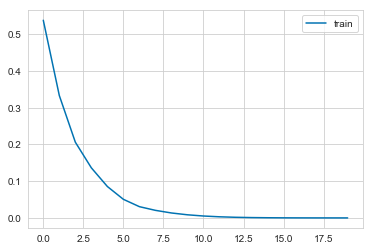

In [29]:
plt.plot(train_run.history['loss'], label='train')
plt.legend()
plt.show()

##### Evaluate model performance

In [30]:
model.evaluate(lstm_test_X, lstm_test_y)

16/16 [==============================] - 0s 405us/step


2.012939512496814e-05

In [31]:
yhat = model.predict(lstm_test_X)

In [32]:
from sklearn.metrics import mean_squared_error

print('rmse: %s' % np.sqrt(mean_squared_error(lstm_test_y, yhat)))

rmse: 0.004486579281487268


### Exploration 2

**Conditional seq2seq GAN** where the discriminator is used to optimise dimension reduction by the (TBD) generator. See https://arxiv.org/pdf/1706.02633.pdf

In [ ]:
record_defaults = [0.0] * num_cols
cols = sorted(list(base_feature_df.columns))
num_cols = len(cols)
feature_cols = list(filter(lambda x: x not in country_labels, cols))
num_features = len(feature_cols)

def parse(line, country=country):
    fields = tf.decode_csv(line, record_defaults)
    features = dict(zip(cols, fields))
    labels = features.pop(country)
    return features, labels

In [ ]:
def lstm_input_fn(filename, hyperparams):
    dataset = tf.data.TextLineDataset(file_name).skip(1)
    dataset = dataset.map(parse)
    dataset = dataset.batch(hyperparams['batch_size'])
    dataset = dataset.repeat(hyperparams['num_epochs'])
    
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [ ]:
file_name = 'features/m_one/combined_%s.csv' % country.lower()